# Modelagem de Série Temporal: SARIMA
Vamos fazer a previsão das temperaturas médias mensais até o ano de 2050 na minha cidade natal, Rio de Janeiro. Para isso, utilizaremos um modelo ARIMA sazonal (SARIMA).

O dataset utilizado é mantido por [Berkeley Earth](http://berkeleyearth.lbl.gov/city-list/) e contém informações climáticas de todo o Globo.

Começamos nossa análise importando as bibliotecas e o dataset:

In [2]:
#importando bibliotecas e módulos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# EDA e Missing Data
Abaixo, vemos que nossos dados contém as temperaturas médias mensais entre 1832 e 2013 para a cidade do Rio de Janeiro. Inspecionamos também o plot:

In [3]:
#Importando os dados e colocando a coluna de datas como index. Assim, já temos uma time series:
df = pd.read_csv('GlobalLandTemperaturesByMajorCity.csv',
                 usecols=['dt', 'AverageTemperature', 'City'], parse_dates=['dt'], index_col='dt') 

#pegando os dados do Rio de Janeiro a partir de 1851
rio_df = df[df.City == 'Rio De Janeiro']

#dropando a coluna de cidade (que agora contem apenas o valor de 'Rio de Janeiro')
rio_df = rio_df.drop('City', axis=1)

#printando o resumo do dataset:
print(rio_df.info())

rio_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2181 entries, 1832-01-01 to 2013-09-01
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   AverageTemperature  2096 non-null   float64
dtypes: float64(1)
memory usage: 34.1 KB
None


,AverageTemperature
dt,
1832-01-01,25.320
1832-02-01,26.584
1832-03-01,25.419
1832-04-01,23.405
1832-05-01,22.773


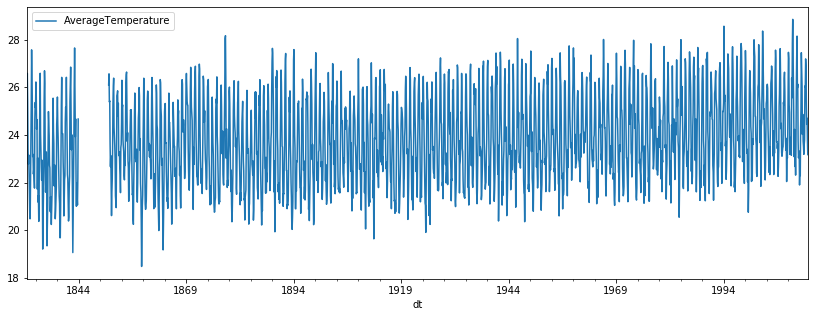

In [3]:
rio_df.plot(figsize=(14,5))

Parece que temos uma janela de missing data entre os anos de 1844 e 1850. Vamos olhá-la mais de perto:

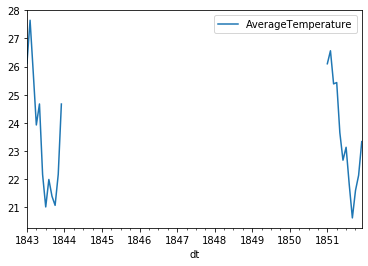

In [4]:
rio_df.loc['1843':'1851'].plot()

Entre 1844 e 1851 não temos dados de temperatura. Para evitar ter que tratar esse missing data, vamos remover da análise tudo que vem antes de 1851. Desse modo, nossa série abrange o intervalo de 1851 até 2013, que acredito ser suficiente para nossa modelagem.

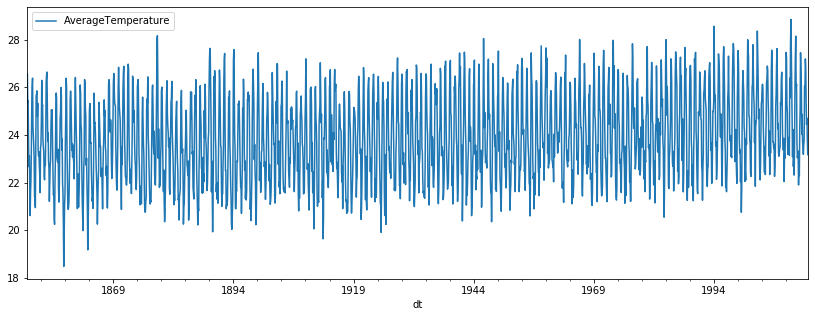

In [5]:
rio_df = rio_df.loc['1851':]
rio_df.plot(figsize=(14,5))

Podemos ver abaixo que temos mais um único valor nulo, correspondente à última data da série (setembro de 2013):

In [6]:
#Temos algum outro valor nulo?
print('Quantidade de valores nulos: ', rio_df.AverageTemperature.isnull().sum())

#Em que data esse valor nulo ocorre?
print('\n\n Quando esse valor nulo ocorre?')
print(rio_df[rio_df.AverageTemperature.isnull()])

Quantidade de valores nulos:  1


 Quando esse valor nulo ocorre?
            AverageTemperature
dt                            
2013-09-01                 NaN


Após removermos esse data point, não temos mais valores nulos na série:

In [7]:
rio_df = rio_df.dropna()

Antes de prosseguir com a análise, vamos separar nosso dataset em conjunto de treinamento e conjunto de teste. Assim evitamos qualquer tipo de data leakage na modelagem que faremos a seguir.

In [8]:
rio_df_train = rio_df[:'2010']
rio_df_test = rio_df['2011':]

# Sazonalidade
Abaixo, por inspeção visual, a série parece ser sazonal, com frequência de 12 meses. Essa consideração é reforçada pelo conhecimento prévio que temos sobre a grandeza medida na série: temperaturas costumam se correlacionar pela estação do ano, que se repetem a cada 12 meses.

Vamos verificar esse período de sazonalidade observando o plot de ACF, mais abaixo.

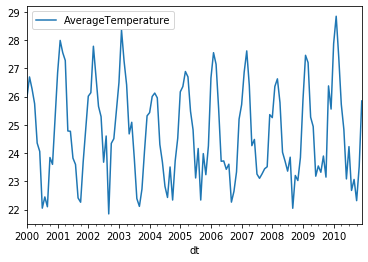

In [9]:
rio_df_train.loc['2000':].plot()

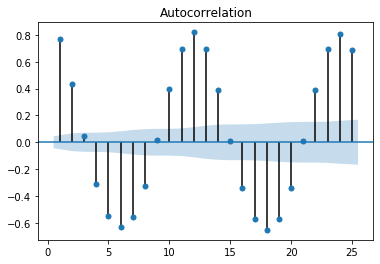

In [10]:
#plotando o ACF:
fig, ax1 = plt.subplots()
plot_acf(rio_df_train.AverageTemperature, lags=25, zero=False,  ax=ax1)
plt.show()

De fato, encontramos uma frequência de sazonalidade de 12 meses, pois o ACF mostra uma alta correlação positiva com lags múltiplos de 12 meses.

Um outro comportamento da série que podemos observar no ACF é que, em "múltiplos ímpares" de 6 meses (6 * 1, 6 * 3, 6 * 5, ...) encontramos uma forte correlação negativa. Isso acontece porque, se hoje é verão, daqui a 6 meses será inverno. Assim, uma temperatura mais alta (típica do verão) está relacionada a uma temperatura mais baixa (típica do inverno) com um lag de 6 meses.

Tendo encontrado o período da sazonalidade, podemos decompor a série temporal em 3 partes: o trend, a sazonalidade e os resíduos locais:

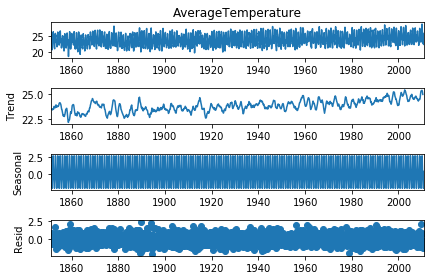

In [11]:
#decompondo a série em trend, sazonalidade e resíduos:
decomp = seasonal_decompose(rio_df_train.AverageTemperature, period=12)
decomp.plot()
plt.show()

Notamos que existe uma tendência de aumento na temperatura, principalmente após 1960, enquanto o fator sazonalidade parece ter influência constante ao longo de todo o período.

# Estacionariedade
Antes de prosseguir com nossa modelagem, precisamos estudar a estacionariedade da série, que é um pressuposto do modelo ARIMA que pretendemos utilizar.

In [12]:
#teste ADF
result = adfuller(rio_df_train.AverageTemperature)
#printando o p-valor:
print('p-valor: ', result[1])

p-valor:  0.0008277657777735445


O teste ADF mostrou um p-valor de ~e-3. Portanto, poderíamos rejeitar a hipótese nula de não estacionariedade e concluir que a série é estacionária, com significância de 1 em 1000.

Contudo, vimos que a série é claramente sazonal. Uma série sazonal não pode ser estacionária, por definição, uma vez que a média da série dependende da época do ano em que medimos a temperatura. O teste ADF nos induziria ao erro, nesse caso, porque ele mede, particularmente, a estacionariedade de trend.

Desse modo, é necessário que removamos sazonalidade da série para torná-la estacionária. Somente após isso poderemos ajustar um modelo ARIMA confiável.

Para remover a sazonalidade da série, vamos fazer as diferenças com lag igual ao período da sazonalidade, 12 meses:

p-valor:  6.609069626036276e-23


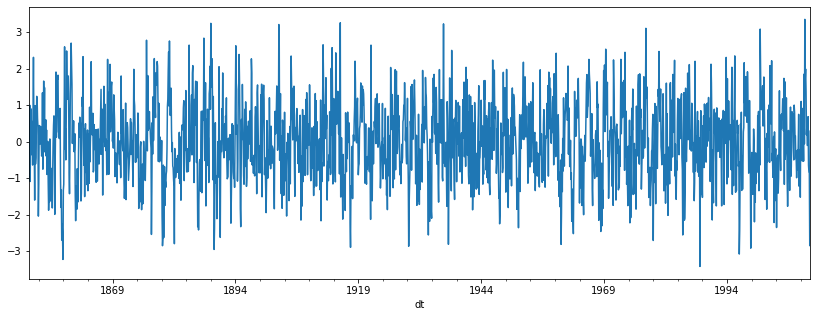

In [13]:
#tirando as diferenças com lag de 12 meses e jogando fora os valores nulos gerados
rio_df_diff = rio_df_train.copy()
rio_df_diff.AverageTemperature = rio_df_train.AverageTemperature.diff(12)
rio_df_diff = rio_df_diff.dropna()

#novo teste ADF
result = adfuller(rio_df_diff.AverageTemperature)
#printando o p-valor:
print('p-valor: ', result[1])

#plotando a série das diferenças de 12 meses
rio_df_diff.AverageTemperature.plot(figsize=(14,5))
plt.show()

Pelo plot, a série de diferenças com lag de 12 meses parece ser estacionária. Isso é fortemente corroborado por um novo teste ADF com p-valor de e-23.

Desse modo, podemos seguir com a modelagem da série.

# Modelagem
Como a série é sazonal, escolheremos um modelo SAMIRA. O modelo SAMIRA é composto de duas partes: um ARIMA não sazonal, de ordens (p,d,q), e um ARIMA sazonal, de ordens (P,D,Q)S, onde:

p e P são as ordens dos respectivos AR.

d e D são as ordens de diferenciação.

q e Q são as ordens dos respectivos MA.

S é o período da sazonalidade.

Já determinamos que S = 12 meses. Além disso, para tornar a série estacionária, fizemos uma única diferenciação múltipla da sazonalidade (logo D=1), e não fizemos nenhuma outra diferenciação (logo d=0).

As ordens (p e P) dos AR e (q e Q) dos MA podem ser inferidas a partir dos plots de ACF e PACF, ou podem ser determinadas pelos critérios de informação (e.g. AIC) encontrados para os diferentes modelos treinados com cada conjunto de ordens. Vamos utilizar o método do critério de informação para encontrar o modelo SARIMA ótimo.

Para a busca dos modelos, utilizaremos a biblioteca pmdarima, criada para imitar a função AUTOARIMA da linguagem R. A finalidade dessa biblioteca é treinar modelos ARIMA com diferentes conjuntos de ordens, e ver qual desses modelos apresenta o menor critério de informação:

In [17]:
import pmdarima as pm

# treinando diferentes modelos e guardando o de menor AIC
#testaremos valores entre 0 e 3 para cada ordem do modelo
model1 = pm.auto_arima(rio_df_train,
                      seasonal=True, m=12,
                      d=0, D=1,
                      start_p=0, start_q=0, start_P=0, start_Q=0,
                      max_p=3, max_q=3, max_P=3, max_Q=3,
                 	  max_order=None,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True)
print(model1.summary())                       

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=5700.803, Time=0.13 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=4939.248, Time=2.23 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=8.10 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=5698.934, Time=0.08 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=5418.702, Time=0.34 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=4700.503, Time=9.86 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=4578.484, Time=20.55 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=84.13 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=37.26 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=4875.845, Time=14.58 sec
 ARIMA(2,0,0)(3,1,0)[12] intercept   : AIC=4556.769, Time=24.88 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=4678.847, Time=11.38 sec
 ARIMA(2,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=93.56 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=40.47 sec
 ARIMA(3,0,0)(3,1,0)[12] intercept  

A busca demorou cerca de 28 minutos para determinar que o modelo ótimo, entre os procurados, é o SARIMA (1,0,2)(3,1,0)12. Assim, a parte não sazonal tem ordens (p,d,q) = (1,0,2), e a parte sazonal tem ordens (P,D,Q)S = (3,1,0)12.

Abaixo, treinamos esse modelo ótimo usando a biblioteca statsmodels.

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(rio_df_train, order=(1,0,2), trend='c', seasonal_order=(3,1,0,12))
results = model.fit()

C:\Users\Marcus-desktop\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Marcus-desktop\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [15]:
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                  AverageTemperature   No. Observations:                 1920
Model:             SARIMAX(1, 0, 2)x(3, 1, [], 12)   Log Likelihood               -2259.725
Date:                             Wed, 23 Sep 2020   AIC                           4535.449
Time:                                     15:45:18   BIC                           4579.880
Sample:                                 01-01-1851   HQIC                          4551.802
                                      - 12-01-2010                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0033      0.008      0.419      0.675      -0.012       0.019
ar.L1          0.8147      

# Dignóstico dos Resíduos
Pelo sumário do modelo acima, com significância de 5%, vemos que o teste de Jarque-Bera rejeita a hipótese nula de normalidade dos resíduos, e o teste de Ljung-Box rejeita a hipótese nula de resíduos não correlacionados. Isso é um mau sinal, pois estaríamos violando esses dois pressupostos do modelo.

Para confirmar essa informação, abaixo fazemos os plots de diagnóstico.

Podemos observar pelo KDE que a distribuição dos resíduos parece ser normal, o que é confirmado pelos datapoints sobre a reta do Q-Q. Já o correlograma mostra que os resíduos, de fato, não apresentam correlação. Soma-se a isso a série temporal dos resíduos, que parece ser white noise, o que é um bom sinal.

Logo, apesar de rejeição dos testes de Ljung-Box e de Jarque-Bera, os plots de diagnóstico mostram que os resíduos são normais e não correlacionados. Desse modo, nosso modelo passou pelo crivo do diagnóstico dos resíduos, e podemos utilizá-lo para forecast com mais segurança.

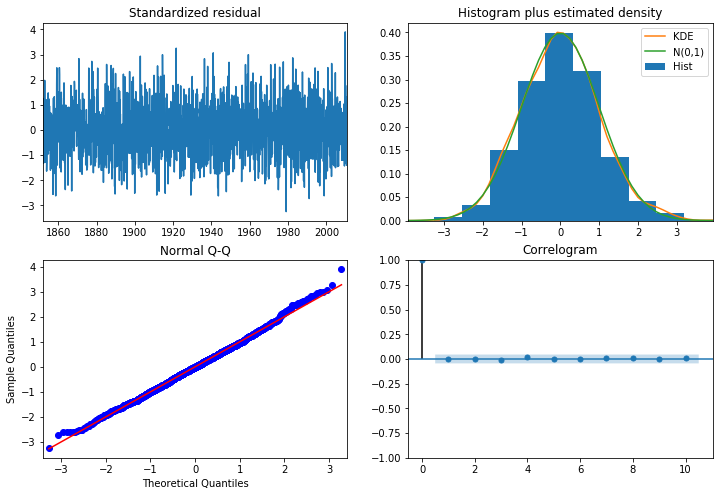

In [16]:
results.plot_diagnostics(figsize=(12,8))
plt.show()

# Avaliação do Modelo
#### Conjunto de treinamento
Abaixo, plotamos as previsões in-sample que nosso modelo fez para o conjunto de treinamento, a partir de 1950. Para comparação, plotamos também os valores reais de temperatura nesse período.


Mean Absolute Error no conjunto de treinamento: 0.6269398846636497



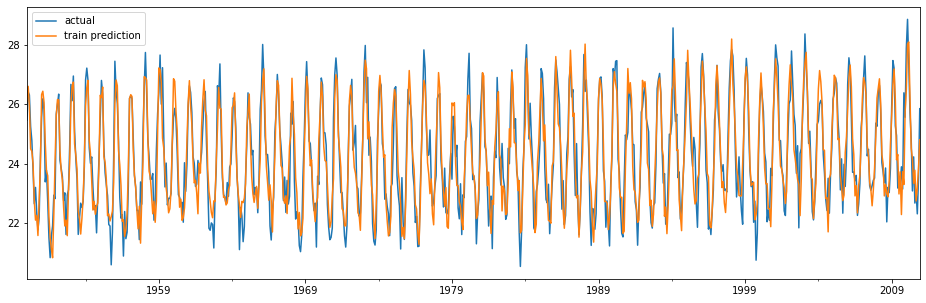

In [46]:
#Mean absolute error no conjunto de treinamento
MAE = np.mean(np.abs(results.resid['1852':]))
print(f"\nMean Absolute Error no conjunto de treinamento: {MAE}\n")

#previsões in-sample:
predictions_train = results.predict(start=0, end=len(rio_df_train)-1)
predictions_train.name = 'train prediction'

#plotando os valores reais e as previsões a partir de 1950:
plot_df_train = pd.concat([rio_df_train.rename(columns={'AverageTemperature': 'actual'}), predictions_train], axis=1)
plot_df_train.loc['1950':].plot(figsize=(16,5))
plt.show()

Para o conjunto de treinamento, encontramos um mean absolute error (MAE) de aproximadamente 0,63°C. Para dar dimensão a esse valor, mostramos abaixo que, no conjunto de treinamento, a temperatura média foi de 23,83°C, com desvio padrão de 1,83°C e amplitude de 10,37°C. Desse modo, consideramos o resultado satisfatório.

In [41]:
media, dp, amplitude = rio_df_train.mean()[0], rio_df_train.std()[0], (rio_df_train.max() - rio_df_train.min())[0]
print('No conjunto de treinamento:\nmédia :', media)
print('desvio padrão :', dp)
print('amplitude: ', amplitude)

No conjunto de treinamento:
média : 23.82651302083335
desvio padrão : 1.8347631698276918
amplitude:  10.366000000000003


#### Conjunto de teste
No conjunto de teste temos 32 pontos nunca vistos pelo nosso modelo. Assim, podemos utilizar esse conjunto para verificar se as previsões do modelo se generalizam bem para novos pontos, ou se existe algum tipo de overfitting no conjunto de treinamento.

Abaixo plotamos as previsões que o modelo fez para o conjunto de teste. Para comparação, plotamos também os valores reais de temperatura no mesmo período.


Mean Absolute Error no conjunto de teste: 0.6103517451339183



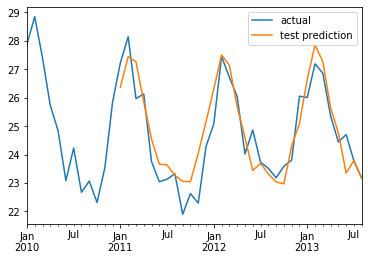

In [51]:
#Mean absolute error no conjunto de teste (pontos nunca vistos pelo algoritmo)
residuals = plot_df_test.loc['2011':].actual - plot_df_test.loc['2011':]['test prediction']
MAE = np.mean(np.abs(residuals))
print(f"\nMean Absolute Error no conjunto de teste: {MAE}\n")

#previsões out of sample usando o conjunto de teste (pontos nunca vistos pelo modelo):
predictions_test = results.predict(start=(len(rio_df_train)), end=(len(rio_df_train)+len(rio_df_test)-1))
predictions_test.name = 'test prediction'

#plotando os valores reais e as previsões do conjunto de teste
plot_df_test = pd.concat([rio_df.rename(columns={'AverageTemperature': 'actual'}), predictions_test], axis=1)
plot_df_test.loc['2010':].plot()
plt.show()

Para o conjunto de teste, encontramos um mean absolute error (MAE) de aproximadamente 0,61°C. Lembrando que o MAE para o conjunto de treinamento foi de 0,63°C, concluímos que nosso modelo generaliza bem para pontos que não foram vistos no treinamento.

Desse modo, podemos fazer forecast para datas que não fazem parte de nosso data set com mais confiança.

Plotamos abaixo, num único gráfico, as temperaturas reais e as temperaturas previstas para o conjunto de treinamento e de teste.

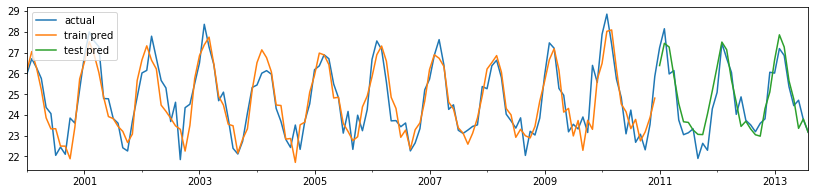

In [53]:
#plotando os valores reais e as previsões para conjuntos de treinamento e teste
plot_df = pd.concat([rio_df.rename(columns={'AverageTemperature': 'actual'}), predictions_train.rename('train pred'), predictions_test.rename('test pred')], axis=1)
plot_df.loc['2000':].plot(figsize=(14,3))
plt.show()

# Forecast
Com nosso modelo treinado e validado, apresentamos abaixo o forecast das temperaturas médias até 2050.

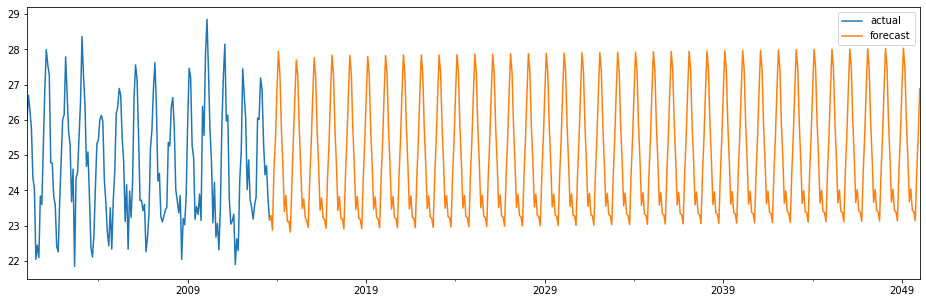

In [80]:
#previsões out of sample usando o conjunto de teste (pontos nunca vistos pelo modelo):
forecast = results.predict(start=(len(rio_df_train)+len(rio_df_test)-1), end=(len(rio_df_train)+len(rio_df_test)-1+437))
forecast.name = 'forecast'

#forecast.plot(label='forecast')
#plt.show()

#plotando os valores reais e as previsões a partir de 1950:
plot_df_train = pd.concat([rio_df.rename(columns={'AverageTemperature': 'actual'}), forecast], axis=1)
plot_df_train.loc['2000':].plot(figsize=(16,5))
plt.show()